In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,RobustScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import shap
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE,ADASYN

In [26]:
# Load the dataset (assuming it has already been loaded as `data`)
data = pd.read_csv('training_data.csv').drop('Unnamed: 0', axis=1)


numerical_columns = data.select_dtypes(include=['float64','int64']).columns.tolist() 

# Function to detect and remove outliers using IQR
def remove_outliers(df, numerical_columns):
    # Q1 = df[numerical_columns].quantile(0.25)
    # Q3 = df[numerical_columns].quantile(0.75)
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR

    # # Filter the DataFrame
    # filtered_df = df[~((df[numerical_columns] < lower_bound) | (df[numerical_columns] > upper_bound)).any(axis=1)]
    return df

# Remove outliers from the DataFrame
df_cleaned = remove_outliers(data, numerical_columns)

# Define the target variable and features

education_mapping = {
    'primary': 0,
    'secondary': 0,
    'tertiary': 1,
    'unknown': 0
}
# poutcome_mapping = {'other':3,'success':2,'unknown':1,'failure':4}
# df_cleaned['poutcome'] = df_cleaned['poutcome'].map(poutcome_mapping)
# df_cleaned['pdays_previous'] = (df_cleaned['pdays']*(df_cleaned['previous']))
# df_cleaned['pdays_previous'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_cleaned.dropna(inplace=True)
# df_cleaned['education'] = df_cleaned['education'].map(education_mapping)
df_cleaned['campaign'] = np.log(1/df_cleaned['campaign']**2)


month_prop_mapping = {1: 0.0030588644898162194,
  2: 0.009673969809256174,
  3: 0.005496008554873044,
  4: 0.012732834299072394,
  5: 0.020840068637934892,
  6: 0.01181268807042849,
  7: 0.014026012782571933,
  8: 0.01574196115490786,
  9: 0.005943647260699809,
  10: 0.0071124816592474695,
  11: 0.009251199920419785,
  12: 0.002163587078162692}
df_cleaned['month_prop'] = df_cleaned['month'].map(month_prop_mapping)


day_prop_map = {1: 0.0018900300912685583,
  2: 0.004028748352440875,
  3: 0.0040784859864216256,
  4: 0.00517271393399816,
  5: 0.004575862326229141,
  6: 0.004028748352440875,
  7: 0.003307552659719977,
  8: 0.004501255875258014,
  9: 0.004028748352440875,
  10: 0.0027107010519509585,
  11: 0.004153092437392753,
  12: 0.005719827907786427,
  13: 0.005446270920892293,
  14: 0.004625599960209893,
  15: 0.005396533286911542,
  16: 0.004277436522344632,
  17: 0.0037800601825371165,
  18: 0.004998632215065529,
  19: 0.002685832234960583,
  20: 0.0043769117903061355,
  21: 0.004426649424286886,
  22: 0.0035811096466141106,
  23: 0.002909651587873965,
  24: 0.0014175225684514188,
  25: 0.002909651587873965,
  26: 0.0024122752480664495,
  27: 0.003357290293700729,
  28: 0.003282683842729601,
  29: 0.0028599139538932135,
  30: 0.0059187784437094325,
  31: 0.0009947526796150307}

contact_prop_map={'cellular': 0.09756036905324414,
  'telephone': 0.008455397776727762,
  'unknown': 0.011837556887418865}


age_category_prop = {'<30': 0.025490537415135163,
  '30-40': 0.040063664171495365,
  '40-50': 0.022754967546193827,
  '50-60': 0.018203974036955062,
  '60+': 0.01134018054761135}
age_bins = [0, 30, 40, 50, 60, 100]
age_labels = ['<30', '30-40', '40-50', '50-60', '60+']
df_cleaned['age_category'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

duration_prop_mapping = {0.0: 4.973763398075154e-05,
 17.0: 9.947526796150308e-05,
 34.0: 4.973763398075154e-05,
 52.0: 0.00019895053592300615,
 69.0: 0.0007709333267016488,
 86.0: 0.0015916042873840492,
 103.0: 0.0019148989082589342,
 121.0: 0.002685832234960583,
 138.0: 0.003431896744671856,
 155.0: 0.0035562408296237347,
 172.0: 0.003531372012633359,
 190.0: 0.003108602123796971,
 207.0: 0.004327174156325384,
 224.0: 0.003655716097585238,
 241.0: 0.003531372012633359,
 259.0: 0.003680584914575614,
 276.0: 0.002984258038845092,
 293.0: 0.0029345204048643408,
 310.0: 0.002909651587873965,
 328.0: 0.002611225783989456,
 345.0: 0.0024868816990375768,
 362.0: 0.0023376687970953222,
 379.0: 0.002536619333018328,
 397.0: 0.002163587078162692,
 414.0: 0.002238193529133819,
 431.0: 0.0016910795553455522,
 448.0: 0.0020641118102011887,
 466.0: 0.0021884558951530677,
 483.0: 0.001616473104374425}

def apply_mapping(value):
    # Sorted keys of the dictionary
    keys = sorted(duration_prop_mapping.keys())
    # Find the largest key less than or equal to the value
    applicable_key = max([key for key in keys if key <= value])
    return duration_prop_mapping[applicable_key]

# df_cleaned['duration_prop'] =df_cleaned['duration'].apply(apply_mapping)

# df_cleaned['age_prop'] = df_cleaned['age_category'].map(age_category_prop)
df_cleaned['day_prop'] = df_cleaned['day'].map(day_prop_map)
df_cleaned['contact'] = df_cleaned['contact'].map(contact_prop_map)

loan_prop_map={'no': 0.10708512596055805, 'yes': 0.010768197756832708}
df_cleaned['loan'] = df_cleaned['loan'].map(loan_prop_map)
df_cleaned['loan'] = np.log(df_cleaned['loan'])

df_cleaned = df_cleaned.drop(['month','day','age'],axis=1)
df_cleaned['y'] = df_cleaned["y"].map({'yes':1,"no":0})

In [27]:
df_cleaned.head(5)

job  marital  education default  balance housing      loan  \
0    management  married   tertiary      no     2143     yes -2.234131   
1    technician   single  secondary      no       29     yes -2.234131   
2  entrepreneur  married  secondary      no        2     yes -4.531158   
3   blue-collar  married    unknown      no     1506     yes -2.234131   
4       unknown   single    unknown      no        1      no -2.234131   

    contact  duration  campaign  pdays  previous poutcome  y  month_prop  \
0  0.011838       261       0.0     -1         0  unknown  0     0.02084   
1  0.011838       151       0.0     -1         0  unknown  0     0.02084   
2  0.011838        76       0.0     -1         0  unknown  0     0.02084   
3  0.011838        92       0.0     -1         0  unknown  0     0.02084   
4  0.011838       198       0.0     -1         0  unknown  0     0.02084   

  age_category  day_prop  
0        50-60  0.004576  
1        40-50  0.004576  
2        30-40  0.004576  
3        40-50  0.004576  
4        30-40  0.004576

In [28]:
X = df_cleaned.drop(columns=['y'])
y = df_cleaned['y']

In [29]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [30]:
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'poutcome',
 'age_category']

In [31]:
X[categorical_features] = X[categorical_features].astype('category')

<h1>Catboost Model Pipeline</h1>

In [32]:
oversample = RandomOverSampler(sampling_strategy=0.3)
undersample = RandomUnderSampler(sampling_strategy=0.36)

In [33]:

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    # remainder='passthrough'
)

# Create a pipeline that includes preprocessing and the model
pipeline_catboost = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
   ('oversample', oversample),
('undersample' , undersample),
    ('classifier', CatBoostClassifier(iterations=10000, learning_rate=0.01, depth=3, eval_metric='AUC', verbose=200))
    # ('classifier', CatBoostClassifier(iterations=5000, learning_rate=0.1, depth=2, eval_metric='Accuracy', verbose=200,cat_features=categorical_features))
])


In [34]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline_catboost.fit(X_train, y_train)



0:	total: 6.88ms	remaining: 1m 8s
200:	total: 1.02s	remaining: 49.8s
400:	total: 2.06s	remaining: 49.3s
600:	total: 3.04s	remaining: 47.6s
800:	total: 4.06s	remaining: 46.6s
1000:	total: 5.17s	remaining: 46.5s
1200:	total: 6.25s	remaining: 45.8s
1400:	total: 7.32s	remaining: 44.9s
1600:	total: 8.33s	remaining: 43.7s
1800:	total: 9.4s	remaining: 42.8s
2000:	total: 10.4s	remaining: 41.8s
2200:	total: 11.5s	remaining: 40.7s
2400:	total: 12.6s	remaining: 39.7s
2600:	total: 13.6s	remaining: 38.7s
2800:	total: 14.7s	remaining: 37.8s
3000:	total: 15.7s	remaining: 36.7s
3200:	total: 16.8s	remaining: 35.8s
3400:	total: 17.9s	remaining: 34.7s
3600:	total: 19s	remaining: 33.7s
3800:	total: 20.1s	remaining: 32.7s
4000:	total: 21.2s	remaining: 31.8s
4200:	total: 22.3s	remaining: 30.8s
4400:	total: 23.4s	remaining: 29.8s
4600:	total: 24.5s	remaining: 28.7s
4800:	total: 25.5s	remaining: 27.6s
5000:	total: 26.5s	remaining: 26.5s
5200:	total: 27.6s	remaining: 25.5s
5400:	total: 28.6s	remaining: 24.4s
5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance', 'loan', 'contact',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'month_prop', 'day_prop']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'poutcome',
                                                   'age_category'])])),
                ('oversample', RandomOverSampler(sampling_strategy=0.3)),
                ('undersample', RandomUnderSampler(sampling_strategy=0.36)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001BBD4132610>)])

In [35]:
# Predict on the test set
y_pred = pipeline_catboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('\n')
print('Classification Report:')
print(report)
print('\n')
print('AUC Score:')
print(roc_auc_score(y_test,y_pred))

Accuracy: 0.8913340793236355


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7085
           1       0.53      0.70      0.61       958

    accuracy                           0.89      8043
   macro avg       0.75      0.81      0.77      8043
weighted avg       0.91      0.89      0.90      8043



AUC Score:
0.8087832213370892


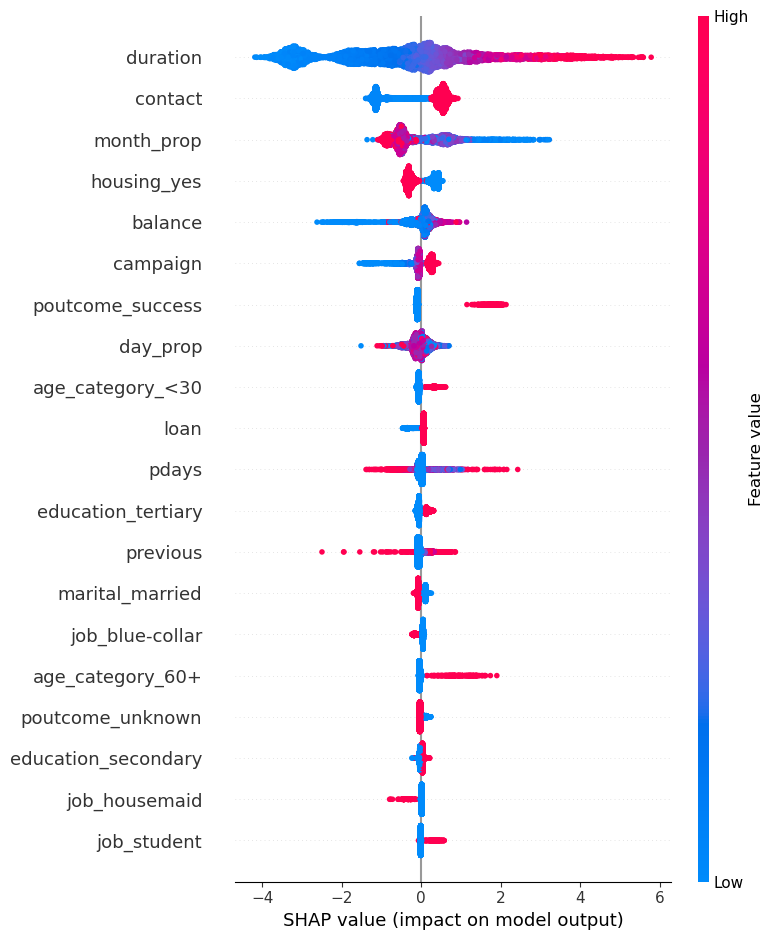

In [36]:
# Calculate SHAP values
explainer = shap.Explainer(pipeline_catboost.named_steps['classifier'])
shap_values = explainer(pipeline_catboost.named_steps['preprocessor'].transform(X_test))

# Get the feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_features):
    num_features = numerical_features
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_features = cat_transformer.get_feature_names_out(categorical_features)
    return np.concatenate([num_features, cat_features])

# After fitting the pipeline, get the feature names
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

# Transform X_test to get the preprocessed data
X_test_preprocessed = pipeline_catboost.named_steps['preprocessor'].transform(X_test)

# Ensure X_test_preprocessed is a DataFrame with the correct feature names
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Now you can use the DataFrame in the SHAP summary plot
shap.summary_plot(shap_values, X_test_preprocessed_df, feature_names=feature_names)